In [1]:
import netCDF4               as netcdf
import numpy                 as np
import matplotlib.pyplot     as plt
import datetime              as datetime  
from matplotlib              import dates as mdates    
from scipy                   import interpolate , signal
import rt_anatools
import xarray as xr
import glob 
import time

In [2]:
dir_nc = 'C:/Users/Usuario/OneDrive - Universitat de les Illes Balears/SWOT/MVP/raw_netcdf_dep_time/leg1/'
#dir_nc = '/Users/everger/OneDrive - Universitat de les Illes Balears/SWOT/MVP/raw_netcdf_dep_time/'
files = glob.glob(dir_nc+'*.nc')
files = np.sort(files)
np.size(files)

347

Directory to save the somoothed files:

In [4]:
#dir_fig = '/Users/everger/OneDrive - Universitat de les Illes Balears/SWOT/MVP/smoothed_profiles/'
dir_fig = 'C:/Users/Usuario/OneDrive - Universitat de les Illes Balears/SWOT/MVP/smoothed_profiles/files_netcdf_smoothed_10m_0.5m/leg1/'

In [8]:
for file in files: 
    ds = xr.open_dataset(file)
    
    '''
    Read variables
    '''
    lon = ds.lon.values
    lat = ds.lat.values
    temp = ds.Temp.values
    sal = ds.Sal.values
    depth = ds.Depth.values
    time = ds.datetime.values
    ds.close()
    
    '''
    Smothing of the dh at the surface
    '''
    scale = 10 # scale of the smoothing in meters
    dz    = 0.5  # horizontal resolution of the interpolated field
    z_final = np.arange(0, 99, dz) # new interpolated axis: CHANGE
    z_original = depth
    
    '''
    ITERATIVE EDITING: remove bad points that are outside 3*variance.
    Repeat editing until we do not have more points outside this rang.
    '''

    # Repeate editing to keep removing bad values --> Iterative editing
    temp_edited = temp.copy() # initialize the variable
    sal_edited = sal.copy()
    N_out_temp     = 10                  # to start the first editing (it could be any number)

    # ITERATIVE EDITING
    # keep editing until N_out = 0

    while N_out_temp>0: 

        # Editing: remove 3 times the variance of the data
        # to remove the points that go too far from the other values
        # 1)smooth 2)look at the residuals
        temp_editsmooth=rt_anatools.loess_smooth_handmade(temp_edited,1/scale,t=z_original) #,t=dist_tran   #canviat posava 1/1000
        sal_editsmooth=rt_anatools.loess_smooth_handmade(sal_edited,1/scale,t=z_original)

        temp_editresiduals = temp_edited-temp_editsmooth
        sal_editresiduals = sal_edited-sal_editsmooth

        id_outlier_temp = np.where(np.abs(temp_editresiduals)>3*np.std(temp_editresiduals))
        id_outlier_sal = np.where(np.abs(sal_editresiduals)>3*np.std(sal_editresiduals))

            # Remove outliers
        temp_edited[id_outlier_temp[0]] = np.nan
        N_out_temp = len(id_outlier_temp[0])

        sal_edited[id_outlier_sal[0]] = np.nan
        N_out_sal = len(id_outlier_sal[0])
        
    '''
    SMOOTH to the desired scale after EDITING. 

    The smooth function can also perform an interpolation. 
    This is the case here, we also perform an
    interpolation to dist_interp in addition to the smoothing
    at the desired scale.
    '''

    # smooth for the desired scale
    temp_smooth = rt_anatools.loess_smooth_handmade(temp_edited,1/scale,t_final=z_final, t=z_original)
    sal_smooth = rt_anatools.loess_smooth_handmade(sal_edited,1/scale,t_final=z_final, t=z_original)
    
#     '''FIGURES'''
#     # Salinity
#     fig,ax = plt.subplots(1)
#     plt.plot(sal,depth,'o',color= 'lightsteelblue',markersize=2,label='Original')
#     plt.plot(sal_smooth,z_final,'-',color= 'midnightblue' ,linewidth = 1.5,label='Smoothed')
#     plt.ylim(0,150)
#     ax.invert_yaxis()
#     plt.title('Salinity MVP profile',size=13)
#     plt.ylabel('Depth(m)')
#     plt.xlabel('Salinity(PSU)')
#     plt.legend()
#     plt.savefig(dir_fig+file[90:-3]+'_S_smoothed_scale_'+str(scale)+'_dz_'+str(dz),dpi=300)
#     plt.close(fig)
    
#     # Temperature
#     fig,ax = plt.subplots(1)
#     plt.plot(temp,depth,'o',color='darksalmon',markersize=2,label='Original')
#     plt.plot(temp_smooth,z_final,'-',color = 'darkred',linewidth = 1.5,label='Smoothed')
#     plt.ylim(0,150)
#     ax.invert_yaxis()
#     plt.title('Temperature MVP profile')
#     plt.ylabel('Depth(m)')
#     plt.xlabel('Temperature(ºC)')
#     plt.legend()
#     plt.savefig(dir_fig+file[90:-3]+'_T_smoothed_scale_'+str(scale)+'_dz_'+str(dz),dpi=300)
#     plt.close(fig)
    
#     # Both
#     fig,ax1 = plt.subplots()
#     pl1 = ax1.plot(sal,depth,'o',color= 'lightsteelblue',markersize=2,label='Original S')
#     pl2 = ax1.plot(sal_smooth,z_final,'-',color= 'midnightblue' ,linewidth = 1.5,label='Smoothed S')
#     ax1.set_ylim(0,150)
#     ax1.invert_yaxis()
#     ax1.tick_params(axis='x',labelcolor = 'midnightblue')
#     ax1.set_ylabel('Depth (m)')
#     ax1.set_xlabel('Salinity (PSU)',color = 'midnightblue')


#     ax2 = ax1.twiny()
#     pl3 = ax2.plot(temp,depth,'o',color='darksalmon',markersize=2,label='Original T')
#     pl4 = ax2.plot(temp_smooth,z_final,'-',color = 'darkred',linewidth = 1.5,label='Smoothed T')
#     ax2.set_ylim(0,150)
#     ax2.invert_yaxis()
#     ax2.tick_params(axis='x',labelcolor = 'darkred')
#     ax2.set_ylabel('Depth (m)')
#     ax2.set_xlabel('Temperature (ºC)',color = 'darkred')

#     # ax.legend(loc='center right')

#     lns = pl1+pl2+pl3+pl4
#     labs = [l.get_label() for l in lns]
#     ax1.legend(lns, labs, loc='center right')

#     fig.tight_layout()

#     plt.savefig(dir_fig+file[90:-3]+'_TandS_smoothed'+str(scale)+'_dz_'+str(dz),dpi=300)
#     plt.close(fig)

    '''
    Save the smoothed profiles in a netcdf file
    '''
    Temp_smooth = xr.DataArray(temp_smooth,name="Temp_smooth",attrs=dict(units="degC"))
    Sal_smooth = xr.DataArray(sal_smooth,name="Sal_smooth",attrs=dict(units="PSS-78"))
    Depth = xr.DataArray(z_final,name="New_depth",attrs=dict(units="m"))
    
    lon = xr.DataArray(lon,name="lon",attrs=dict(units="decimal degree"))
    lat = xr.DataArray(lat,name="lat",attrs=dict(units="decimal degree"))
    time = xr.DataArray(time,name="time",attrs=dict(units="%d/%m/%Y %H:%M:%S"))
    
    DS = xr.merge([Depth, Temp_smooth, Sal_smooth, lon,lat, time])

    namefile = file[95:-3] + '_scale_' + str(scale) + '_dz_'+str(dz) + '_smoothed.nc' # OJO!! CANVIAR SI CANVIA EL DIRECTORI !!!
    DS.to_netcdf(path= dir_fig + namefile)


Figure to see all the smoothed profiles:

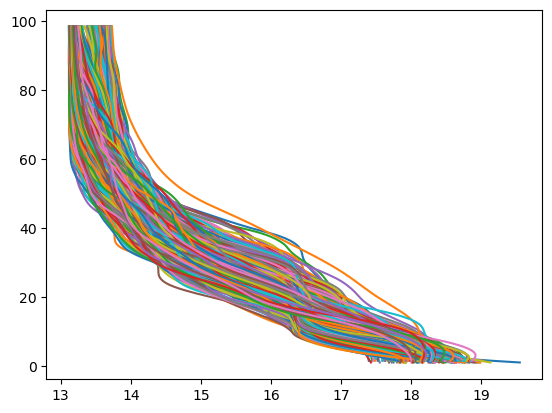

In [16]:
dir_fig = 'C:/Users/Usuario/OneDrive - Universitat de les Illes Balears/SWOT/MVP/smoothed_profiles/files_netcdf_smoothed_10m_0.5m/leg1/'
files = glob.glob(dir_fig+'*.nc')
for file in files: 
    ds = xr.open_dataset(file)
    plt.plot(ds.Temp_smooth,ds.New_depth)